In [1]:
import sys
import pandas as pd
import numpy as np
import os
import itertools
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc

import matplotlib as mpl
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
font = {'family': 'arial',
        'size': 14}
mpl.rc('font', **font)

%matplotlib inline

# General Functions and Classess

In [2]:
def lighten_color(color, amount=0.3):
        """
        Lightens the given color by multiplying (1-luminosity) by the given amount.
        Input can be matplotlib color string, hex string, or RGB tuple.

        Examples:
        >> lighten_color('g', 0.3)
        >> lighten_color('#F034A3', 0.6)
        >> lighten_color((.3,.55,.1), 0.5)
        """
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
def ranksum(caseVals, controlVals):

    s, p = stats.ranksums(caseVals, controlVals)
    return p

In [4]:
class rocplot():
    '''
    Dataframe should have two columns, one contaning values for cases and other for controls.
    '''

    def __init__(self, df, cases=None, controls=None):

        import pandas as pd
        import numpy as np
        from sklearn.metrics import roc_curve

        # select cases/ctrl vals based on order in df (0,1) or columns labels if strings
        if cases != None:
            self.caseVals = df[cases].dropna().tolist()
        else:
            self.caseVals = df.iloc[:, 0].dropna().tolist()
        if controls != None:
            self.controlVals = df[controls].dropna().tolist()
        else:
            self.controlVals = df.iloc[:, 1].dropna().tolist()

        self.values = self.caseVals + self.controlVals
        self.labels = [1 for i in self.caseVals] + \
            [0 for i in self.controlVals]
        self.fpr, self.tpr, self.thresholds = roc_curve(
            self.labels, self.values)

        optimal_idx = np.argmax(self.tpr - self.fpr)
        self.optimal_threshold = self.thresholds[optimal_idx]
        self.sensitivity = self.tpr[optimal_idx]
        self.specificity = 1 - self.fpr[optimal_idx]

    @property
    def AUC(self):

        roc_auc = auc(self.fpr, self.tpr)
        return roc_auc

    def plot(self):

        lw = 2

        plt.plot(self.fpr, self.tpr, color='red', lw=lw,
                 label='AUC = %0.2f' % self.AUC)

        plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.00])
        plt.ylim([0.0, 1.00])
        plt.xlabel('FPR', fontsize=26)
        plt.ylabel('TPR', fontsize=26)
        plt.xticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                           for i in np.arange(0, 1.1, .2)], fontsize=20)
        plt.yticks(np.arange(0, 1.1, .2), [str(round(i, 2))
                                           for i in np.arange(0, 1.1, .2)], fontsize=20)
#         plt.legend(loc="lower right", fontsize=12, edgecolor='k')

        return plt

# Figure 1 - Mutation vs Hypermethylation Frequencies

## Paths to Data

In [5]:
mutationFiles = 'mutationFreqs/'

sampleFileCallID = {'KIRC': 'Raw_Calls',
                    'BLCA': 'Calls',
                    'STAD': 'Raw_Calls',
                    'HNSC': 'Raw_Calls',
                    'PRAD': 'Raw_Calls',
                    'KIRP': 'Raw_Calls',
                    'LIHC': 'Raw_Calls',
                    'LUAD': 'Calls',
                    'PAAD': 'Calls',
                    'BRCA': 'Calls',
                    'OV': 'Calls'}

methylationArrayPath = 'methylationArrayData/'

## Functions

### ```sampleMutationFreqTable```

In [6]:
def sampleMutationFreqTable(cancerGenes, sampleMutationFiles, sampleFilesFolder):
    
    '''
    Return table where each row is sample and each column is cancer associated gene.
    Each cell is mutation call for that gene for given sample.
    NaN if sample does not have mutation of given type in that gene.
    '''
    
    genes = cancerGenes.values
    sampleMutTable = pd.DataFrame(columns=genes)
    
    # positions of genes in rows:
    genePosDict = {}
    for pos, gene in enumerate(genes):
        genePosDict[gene] = pos
    
    # for each sample file, load into to DF, get sample barcode, and check mutation status for given genes
    for f in sampleMutationFiles:
        if 'TCGA' in f:
            path = sampleFilesFolder + f
            # replace '-' with '.' to match up with methylation table
            sample = ".".join(f.split('.maf.txt')[0].split('-'))
            # get slice of table for top genes and get mutation status
            table = pd.read_table(path, engine='python')

            sample_mutation_status = [np.nan]*len(genes) # list of nans to be filled with mutation status for sample
            for gene in genes:
                idx = genePosDict[gene]
                
                # check if mutations in gene for sample are not silent and are SNPs:
                table_slice = table[table['Hugo_Symbol'] == gene][[
                    'Variant_Classification', 'Variant_Type']]
                check_mut_type = table_slice[(table_slice['Variant_Classification'] != 'Silent') & (
                    table_slice['Variant_Type'] == 'SNP')]
                
                # append mutation status of gene for given sample to sample_mutation_status
                if len(check_mut_type) > 0:
                    sample_mutation_status[idx] = 'SNP'
                else:
                    continue
            
            # append sample as row with mutation statuses
            sampleMutTable.loc[sample] = sample_mutation_status
            
    return sampleMutTable

### ```summaryTable```

In [7]:
def summaryTable(mutTableWithMeth, controlsBetaValues, cancerGenes):

    summary = {}

    totTumors = float(len(mutTableWithMeth))
    totControls = float(len(controlsBetaValues))
    betaCutoff = np.percentile(controlsBetaValues, 95)
    
    # ---------------------------------------------------------
    # counts of tumors with different numbers of mutations:
    # counters
    none = 0
#     both = 0
#     All = 0
#     _2mutations = 0
#     _3orMore = 0
    Any = 0

    tumorsWithMeth = mutTableWithMeth.iloc[:, :-1]

    for index, row in tumorsWithMeth.iterrows():
        if row.count() == 0:
            none += 1
            
#         elif row.count() == 1:
#             Any += 1
#         elif row.count() == 2 and len(cancerGenes.values) == 2:
#             both += 1
#             Any += 1
#         elif row.count() == len(cancerGenes.values):
#             Any += 1
#             All += 1
#         elif row.count() == 2 and len(cancerGenes.values) > 2:
#             _2mutations += 1
#             Any += 1
#         elif row.count() > 2 and row.count() < len(cancerGenes.values):
#             _3orMore += 1
#             Any += 1
        
        elif row.count() >= 1:
            Any += 1
        
        else:
            pass
    # ---------------------------------------------------------

    summary['total tumors'] = totTumors
    summary['total controls'] = totControls
    summary['beta cutoff'] = betaCutoff
    summary['cg21790626 hypermethylation frequency'] = round(
        (len(mutTableWithMeth[mutTableWithMeth.iloc[:, -1] > betaCutoff])/totTumors) * 100, 1)
    
    for gene in cancerGenes.values:
        summary[gene] = round(
            (len(mutTableWithMeth[gene].dropna())/totTumors) * 100, 1)
    
    summary['Any'] = round((Any/totTumors) * 100, 1)
    
    return(summary)

### Plot Function ```mutationVShypermethylation```

In [8]:
def mutationVShypermethylation(allCancerTypes):

    fig, ax = plt.subplots(figsize=(8, 6))

    colors = iter(cm.hsv(np.linspace(0, 1, allCancerTypes.shape[0])))
    colors

    for idx, row in allCancerTypes.iterrows():
        ax.scatter(float(row['% mutated'] / 100.0), float(row['% hypermethylated'] / 100.0),
                   c=np.array([next(colors)]), s=100, label=idx)

    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_xticklabels([str(int(i*100)) + "%"
                        for i in np.arange(0, 1.1, 0.2)], fontsize=22)

    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_yticklabels([str(int(i*100)) + "%"
                        for i in np.arange(0, 1.1, 0.2)], fontsize=22)

    plt.legend(bbox_to_anchor=(1.01, 1.03),
               loc='upper left', fontsize=20, edgecolor='k')

    plt.grid()

    plt.plot([0, 1], [0, 1], color='k', linestyle='--')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.ylabel('% tumors hypermethylated\n(cg21790626)')
    plt.xlabel('% tumors with mutation in\n cancer gene set*')
    
    return plt

## Analysis

In [9]:
# master frequency table for all cancer types for plotting
allCancerTypes = pd.DataFrame(
    columns=['Tumors', 'Controls', 'beta cutoff', '% hypermethylated', '% mutated'])

for key, value in sampleFileCallID.items():

    # select cancer associated mutated genes:
    geneFreqFile = mutationFiles + '{}/Mutated_Genes.txt'.format(key)
    geneFreqDF = pd.read_table(geneFreqFile)
    geneFreqDF['frac'] = [
        float(i)/100.0 for i in geneFreqDF['Freq'].str.strip('%')]

    cancerGenesDF = geneFreqDF[geneFreqDF['Is Cancer Gene (source: OncoKB)'] == 'Yes']
    
    if key == 'KIRP':
        # KIRP has no genes with freq > 10%, so take top 2
        cancerGenes = cancerGenesDF['Gene'][:2]
    else:
        cancerGenes = cancerGenesDF[cancerGenesDF['frac'] > 0.10]['Gene']

    # get files for individual samples for given tissue:
    sampleFilesFolder = mutationFiles + \
        '{}/gdac.broadinstitute.org_{}.Mutation_Packager_{}.Level_3.2016012800.0.0/'.format(
            key, key, value)
    
    sampleMutationFiles = []
    for (dirpath, dirnames, filenames) in os.walk(sampleFilesFolder):
        sampleMutationFiles.extend(filenames)
        break
    sampleMutationFiles

    # build mutation frequency table for samples based on selected cancer associated genes:
    sampleMutationTable = sampleMutationFreqTable(
        cancerGenes, sampleMutationFiles, sampleFilesFolder)

    # -------------------------------------------------------------------------

    # get methylation array beta values for ZNF154 for samples:
    if key == 'OV':
        methylationFile = methylationArrayPath + \
            '{}_27K_ZNF154.txt'.format(key)
    else:
        methylationFile = methylationArrayPath + \
            '{}_450K_ZNF154.txt'.format(key)
        
    methylationDF = pd.read_table(methylationFile, index_col=0)

    # reformatting based on gdac methylation data file structure
    methylationDF_Reformat = methylationDF[[
        i for i in methylationDF.columns if '.' not in i]].loc['cg21790626']
    methylationDF_Reformat.index = [
        ".".join(i[0:15].split('-')) for i in methylationDF_Reformat.index]

    controlsBetaValues = methylationDF_Reformat[methylationDF_Reformat.index.str.endswith(
        '.11')]
    tumorsBetaValues = methylationDF_Reformat[methylationDF_Reformat.index.str.endswith(
        '.01')]

    # -------------------------------------------------------------------------
    # combine mutation and methylation information for tumor samples for given cancer type

    mutTableWithMeth = pd.concat(
        [sampleMutationTable, tumorsBetaValues], axis=1, join='inner')

    mutTableWithMeth = mutTableWithMeth[pd.notnull(
        mutTableWithMeth['cg21790626'])]

    # -------------------------------------------------------------------------

    cancerTypeSummary = summaryTable(
        mutTableWithMeth, controlsBetaValues, cancerGenes)

    # append summary to master frquency table for subsequent plotting:
    row = [cancerTypeSummary['total tumors'],
           cancerTypeSummary['total controls'],
           cancerTypeSummary['beta cutoff'],
           cancerTypeSummary['cg21790626 hypermethylation frequency'],
           cancerTypeSummary['Any']]
    
    allCancerTypes.loc[key] = row

allCancerTypes

,Tumors,Controls,beta cutoff,% hypermethylated,% mutated
KIRC,263.0,160.0,0.016482,75.3,52.9
BLCA,130.0,21.0,0.316176,94.6,63.8
STAD,349.0,2.0,0.161044,96.6,82.5
HNSC,510.0,50.0,0.180760,98.6,85.3
PRAD,498.0,50.0,0.523035,52.0,20.5
KIRP,267.0,45.0,0.024678,50.6,7.5
LIHC,373.0,50.0,0.057879,90.1,46.9
LUAD,185.0,32.0,0.071018,75.7,85.4
PAAD,150.0,10.0,0.069513,90.7,95.3
BRCA,664.0,97.0,0.189592,74.4,54.2


## Plot

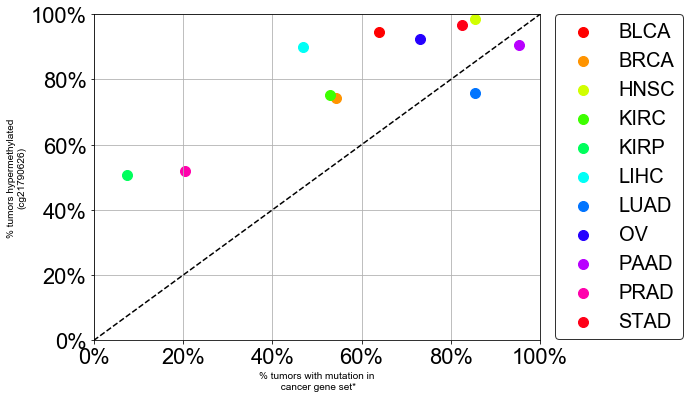

In [10]:
figure1 = mutationVShypermethylation(allCancerTypes.sort_index())
# figure1.show()

figure1.savefig('Figure1.png',
                bbox_inches='tight', pad_inches=0.5, dpi=600)

# Figure 2 - Stage I Solid Tumors cg21790626 Beta Value Distributions

## Cancer IDs and Early Stage Samples

In [11]:
cancerTypes = ['STAD', 'KIRP', 'HNSC', 'BLCA', 'BRCA', 'LUAD', 'KIRC', 'PAAD', 'Serous_EOC', 'LIHC']

In [12]:
earlyStageSamples = pd.read_table('methylationArrayData/TCGA_earlyStage_samples.txt')
earlyStageSamples

,sampleID,Stage,Classification,Cancer
0,TCGA-BL-A0C8-01,Stage_I,pathologic_stage,BLCA
1,TCGA-FJ-A3Z9-01,Stage_I,pathologic_stage,BLCA
2,TCGA-A1-A0SB-01,Stage_I,pathologic_stage,BRCA
3,TCGA-A1-A0SE-01,Stage_I,pathologic_stage,BRCA
4,TCGA-A2-A0EP-01,Stage_I,pathologic_stage,BRCA
...,...,...,...,...
1054,TCGA-FI-A2D0-01,Stage_IA,clinical_stage,UCEC
1055,TCGA-FI-A2EU-01,Stage_IA,clinical_stage,UCEC
1056,TCGA-FI-A2F9-01,Stage_IA,clinical_stage,UCEC
1057,TCGA-FI-A3PV-01,Stage_IA,clinical_stage,UCEC


## Bartlett Data

In [13]:
# 221 OV samples path:
eocSampleInfoPath = 'methylationArrayData/Bartlett/GSE72021_series_matrix.txt'
eocBetaValuesPath = 'methylationArrayData/Bartlett/GSE72021_AverageBetaValues 2.csv'

# 216 Fallopian Tube Controls:
ftDataPath = 'methylationArrayData/Bartlett/2015_Bartlett_fallopian_tube_samples_GSE74845_series_matrix_2.txt'

In [14]:
# Select samples of interest by ID
eoc_label_df = pd.read_table(
    eocSampleInfoPath, skiprows=26, index_col=0, header=None)
EOCLabels = eoc_label_df.loc[['!Sample_title', '!Sample_description',
                              '!Sample_characteristics_ch1']].T.iloc[:, [0, 1, 5]]
EOCLabels.columns = ['Type', 'Sample', 'Stage']
EOCLabels['Type'] = EOCLabels['Type'].str.split(' ').str[0]
EOCLabels['Stage'] = EOCLabels['Stage'].str.split(' ').str[1]

EOCLabels['Stage'] = pd.to_numeric(EOCLabels['Stage'], errors='coerce')

EarlySerousSamples = EOCLabels[ (EOCLabels['Type'] == 'serous') & ( EOCLabels['Stage'] == 1 )]
EarlySerousSamples

,Type,Sample,Stage
108,serous,Sample108,1
132,serous,Sample132,1
151,serous,Sample151,1
193,serous,Sample193,1
196,serous,Sample196,1
199,serous,Sample199,1
201,serous,Sample201,1


In [15]:
eocBetaValue = pd.read_csv(eocBetaValuesPath, index_col=0)
eocBetaValue

,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,Sample10,...,Sample212,Sample213,Sample214,Sample215,Sample216,Sample217,Sample218,Sample219,Sample220,Sample221
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.19462,0.25000,0.22352,0.27041,0.39602,0.27218,0.26030,0.17821,0.14310,0.43044,...,0.49797,0.20376,0.424530,0.25253,0.38367,0.32116,0.15027,0.38103,0.18857,0.21171
cg00000165,0.13601,0.47873,0.26978,0.24587,0.39835,0.54589,0.73611,0.24301,0.43061,0.76439,...,0.41214,0.71000,0.531590,0.40299,0.79948,0.41207,0.22227,0.31870,0.80539,0.29536
cg00000236,0.89565,0.88678,0.89101,0.92595,0.91339,0.89206,0.90170,0.85631,0.91185,0.89163,...,0.89350,0.92510,0.656130,0.88547,0.84562,0.90423,0.91883,0.91078,0.90047,0.91121
cg00000289,0.64114,0.50600,0.57868,0.62456,0.54298,0.64401,0.59091,0.54305,0.75973,0.67500,...,0.60943,0.70253,0.439447,0.54289,0.62472,0.68214,0.70229,0.65263,0.69807,0.75197
cg00000292,0.68781,0.82335,0.86111,0.92079,0.84273,0.78214,0.88271,0.87749,0.70540,0.83816,...,0.85111,0.90821,0.817950,0.89114,0.81808,0.72325,0.90952,0.73871,0.77836,0.74875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg27665860,0.86177,0.88661,0.87749,0.88432,0.86489,0.86954,0.89235,0.81905,0.87590,0.79101,...,0.83260,0.89059,0.882630,0.87445,0.87312,0.82317,0.88494,0.78689,0.83208,0.80861
cg27665925,0.02357,0.01686,0.02698,0.01380,0.01832,0.02066,0.03860,0.03057,0.02679,0.02540,...,0.02232,0.03253,0.170480,0.02477,0.27520,0.02242,0.01623,0.03050,0.01566,0.01365
cg27665985,0.26722,0.21004,0.24243,0.29544,0.35638,0.23516,0.35492,0.28776,0.38698,0.17836,...,0.34562,0.51657,0.332900,0.30252,0.20033,0.30591,0.40448,0.28286,0.28820,0.29040


In [16]:
EarlySerousBetas = eocBetaValue.loc['cg21790626', EarlySerousSamples['Sample'].values]
EarlySerousBetas

Sample108    0.76534
Sample132    0.79050
Sample151    0.49273
Sample193    0.63197
Sample196    0.79009
Sample199    0.03598
Sample201    0.02665
Name: cg21790626, dtype: float64

In [17]:
ft_df = pd.read_table(ftDataPath, skiprows=46, index_col=0, header=0)
ft_df.loc['cg21790626']

/Users/millerbf2/miniconda3/envs/py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=co

Sample1      0.0222535
Sample2      0.0347432
Sample3      0.0424989
Sample4      0.0257681
Sample5       0.176082
               ...    
Sample212    0.0703746
Sample213    0.0117746
Sample214     0.104848
Sample215     0.085448
Sample216    0.0630573
Name: cg21790626, Length: 216, dtype: object

In [18]:
fallopianTubeValues = ft_df.loc['cg21790626']
fallopianTubeValues

Sample1      0.0222535
Sample2      0.0347432
Sample3      0.0424989
Sample4      0.0257681
Sample5       0.176082
               ...    
Sample212    0.0703746
Sample213    0.0117746
Sample214     0.104848
Sample215     0.085448
Sample216    0.0630573
Name: cg21790626, Length: 216, dtype: object

## Plot

/Users/millerbf2/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/Users/millerbf2/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/Users/millerbf2/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentati

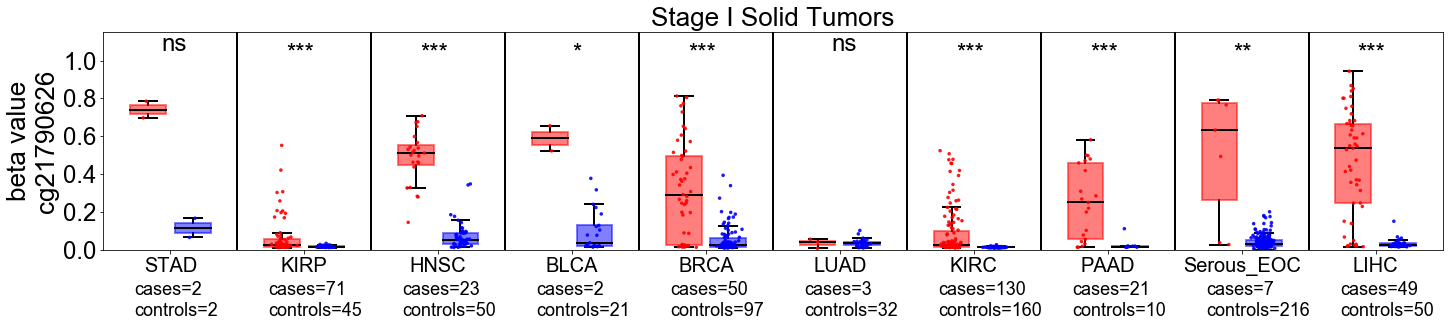

In [19]:
fig, ax = plt.subplots(figsize=(24, 4))
ax.set_ylim([0, 1.15])

labels = []
x_label_positions = []
position = 1

for cancerID in cancerTypes:

    if cancerID == 'Serous_EOC':
        # -------------------------------------------------------------------------
        # for Bartlett Data post-processed and filtered:
        
        controlsBetaValues = fallopianTubeValues
        earlyTumorValues = EarlySerousBetas
        
        numCases = len(earlyTumorValues)
        numControls = len(controlsBetaValues)

    else:
        # -------------------------------------------------------------------------
        # for TCGA datasets:

        # early stage tumor samples
        earlyStageIDs = ['.'.join(i.split(
            '-')) for i in earlyStageSamples[earlyStageSamples['Cancer'] == cancerID]['sampleID'].values.tolist()]

        methylationFile = methylationArrayPath + '{}_450K_ZNF154.txt'.format(cancerID)
        methylationDF = pd.read_table(methylationFile, index_col=0)

        # reformatting based on gdac methylation data file structure
        methylationDF_Reformat = methylationDF[[
            i for i in methylationDF.columns if '.' not in i]].loc['cg21790626']
        methylationDF_Reformat.index = [
            ".".join(i[0:15].split('-')) for i in methylationDF_Reformat.index]

        controlsBetaValues = methylationDF_Reformat[methylationDF_Reformat.index.str.endswith(
            '.11')]
        tumorsBetaValues = methylationDF_Reformat[methylationDF_Reformat.index.str.endswith(
            '.01')]
        earlyTumorValues = tumorsBetaValues.loc[earlyStageIDs].dropna()
        
        numCases = len(earlyTumorValues)
        numControls = len(controlsBetaValues)
        
    # -------------------------------------------------------------------------
    # Plotting:

    if numCases == 0 or numControls == 0:
        continue
    else:
        labels.append(cancerID)
        x_label_positions.append(position)

        bp = ax.boxplot([earlyTumorValues, controlsBetaValues],
                        positions=[position-0.25, position+0.25],
                        widths=0.4, patch_artist=True)

        for flier in bp['fliers']:
            flier.set(marker='', color='black')
        for whisker in bp['whiskers']:
            whisker.set(color='black', linewidth=2)
        for cap in bp['caps']:
            cap.set(color='black', linewidth=2)
        for median in bp['medians']:
            median.set(color='black', linewidth=2)

        bp['boxes'][0].set(color='red', facecolor=lighten_color(
            'red'), linewidth=2, alpha=0.5)
        bp['boxes'][1].set(color='blue', facecolor=lighten_color(
            'blue'), linewidth=2, alpha=0.5)

        scatter = ax.scatter(x=np.random.normal(position-0.25, 0.05, size=len(earlyTumorValues)),
                             y=earlyTumorValues, c='r', marker='.', edgecolors='', s=50, alpha=0.9, zorder=10)

        scatter = ax.scatter(x=np.random.normal(position+0.25, 0.05, size=len(controlsBetaValues)),
                             y=controlsBetaValues, c='b', marker='.', edgecolors='', s=50, alpha=0.9, zorder=10)

        pval = ranksum(earlyTumorValues, controlsBetaValues)

        if 0.01 <= pval < 0.05:
            ax.text(x=position, y=1.0, s='*', fontsize=24)
        if 0.001 <= pval < 0.01:
            ax.text(x=position-0.10, y=1.0, s='**', fontsize=24)
        if pval < 0.001:
            ax.text(x=position-0.20, y=1.0, s='***', fontsize=24)
        if pval >= 0.05:
            ax.text(x=position-0.10, y=1.05, s='ns', fontsize=24)

        ax.text(x=position-0.40, y=-0.35,
                s='cases={}\ncontrols={}'.format(numCases, numControls), fontsize=18)

        position += 1.5
        
# -------------------------------------------------------------------------

ax.axvline(x=1.75, color='k', linewidth=2)
ax.axvline(x=3.25, color='k', linewidth=2)
ax.axvline(x=4.75, color='k', linewidth=2)
ax.axvline(x=6.25, color='k', linewidth=2)
ax.axvline(x=7.75, color='k', linewidth=2)
ax.axvline(x=9.25, color='k', linewidth=2)
ax.axvline(x=10.75, color='k', linewidth=2)
ax.axvline(x=12.25, color='k', linewidth=2)
ax.axvline(x=13.75, color='k', linewidth=2)
# ax.axvline(x=15.25, color='k', linewidth=2)
# ax.axvline(x=16.75, color='k', linewidth=2)
# ax.axvline(x=18.25, color='k', linewidth=2)
# ax.axvline(x=19.75, color='k', linewidth=2)

# -------------------------------------------------------------------------
# axes labeling

ax.set_xticks(x_label_positions)
ax.set_xticklabels(labels, fontsize=20)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([str(round(i, 1))
                    for i in np.arange(0, 1.1, 0.2)], fontsize=24)

ax.set_ylabel('beta value\ncg21790626', fontsize=26)

plt.title('Stage I Solid Tumors', fontsize=26)

# plt.show()

fig.savefig('Figure2.png',
            bbox_inches='tight', pad_inches=0.5, dpi=600)

# Figure 3 - ZNF154 methylation across ages and sex

## Paths to Peripheral Blood Beta Values and Information

In [20]:
peripheralBloodBetasPath = 'methylationArrayData/peripheralBlood/GSE55763_normalized_betas_ZNF154.txt'
sampleInfoPath = 'methylationArrayData/peripheralBlood/GSE55763_series_matrix.txt'

## Data Processing

In [21]:
peripheralBetas = pd.read_csv(peripheralBloodBetasPath, index_col=0)

In [22]:
info = []
with open(sampleInfoPath) as meta:
    for line in meta:
        if '!Sample_title' in line:
            vals = line.split("\t")
            info.append(vals)
        if 'age:' in line:
            vals = line.split("\t")
            info.append(vals)
        if 'gender' in line:
            vals = line.split("\t")
            info.append(vals)
raw_info = pd.DataFrame(info)
raw_info

,0,1,2,3,4,5,6,7,8,9,...,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711
0,!Sample_title,"""Peripheral blood, 7786915023_R02C02""","""Peripheral blood, 7786915135_R04C02""","""Peripheral blood, 7471147149_R06C01""","""Peripheral blood, 7786915035_R05C01""","""Peripheral blood, 7786923035_R01C01""","""Peripheral blood, 7471147072_R01C02""","""Peripheral blood, 7471147107_R05C02""","""Peripheral blood, 7786923028_R05C02""","""Peripheral blood, 7512560087_R03C01""",...,"""Peripheral blood, 7796814021_R01C02""","""Peripheral blood, 7796814021_R02C01""","""Peripheral blood, 7796814021_R03C01""","""Peripheral blood, 7796814021_R03C02""","""Peripheral blood, 7796814021_R04C01""","""Peripheral blood, 7796814021_R04C02""","""Peripheral blood, 7796814021_R05C01""","""Peripheral blood, 7796814021_R05C02""","""Peripheral blood, 7796814021_R06C01""","""Peripheral blood, 7796814021_R06C02""\n"
1,!Sample_characteristics_ch1,"""gender: M""","""gender: M""","""gender: M""","""gender: M""","""gender: M""","""gender: M""","""gender: M""","""gender: M""","""gender: M""",...,"""gender: M""","""gender: M""","""gender: M""","""gender: F""","""gender: M""","""gender: M""","""gender: M""","""gender: F""","""gender: M""","""gender: F""\n"
2,!Sample_characteristics_ch1,"""age: 57.9""","""age: 42""","""age: 47.4""","""age: 49.3""","""age: 52.5""","""age: 54.6""","""age: 59.7""","""age: 52.3""","""age: 60.3""",...,"""age: 35.5""","""age: 35.9""","""age: 51.3""","""age: 45.3""","""age: 50.6""","""age: 52.7""","""age: 44.3""","""age: 46.4""","""age: 39.5""","""age: 52.5""\n"


In [23]:
gender = [i.split()[1][0] for i in raw_info.loc[1] if 'gender' in i]
age = [float(i.split()[1][:-1]) for i in raw_info.loc[2] if 'age' in i]
sample = [i.split()[2][:-1] for i in raw_info.loc[0] if 'Peripheral blood' in i]
info = pd.DataFrame([age, gender], columns=sample, index=['age', 'gender'])

In [24]:
peripheralZNFbetas = peripheralBetas.loc['cg21790626'].to_frame()

In [25]:
peripheralZNFbetasInfo = pd.concat([info.T, peripheralZNFbetas], axis=1, sort=False)

In [26]:
males = peripheralZNFbetasInfo[peripheralZNFbetasInfo['gender'] == 'M']
females = peripheralZNFbetasInfo[peripheralZNFbetasInfo['gender'] == 'F']

In [27]:
# age categories:
maleAgeCategories = pd.cut(males['age'].values, [0,40, 50, 60, 70, 90])
maleAgeCategories

[(50, 60], (40, 50], (40, 50], (40, 50], (50, 60], ..., (50, 60], (50, 60], (50, 60], (40, 50], (0, 40]]
Length: 1840
Categories (5, interval[int64]): [(0, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 90]]

In [28]:
males['Age'] = maleAgeCategories
males

/Users/millerbf2/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,age,gender,cg21790626,Age
7786915023_R02C02,57.9,M,0.086995,"(50, 60]"
7786915135_R04C02,42,M,0.093055,"(40, 50]"
7471147149_R06C01,47.4,M,0.019346,"(40, 50]"
7786915035_R05C01,49.3,M,0.075207,"(40, 50]"
7786923035_R01C01,52.5,M,0.029225,"(50, 60]"
...,...,...,...,...
7796814021_R03C01,51.3,M,0.028391,"(50, 60]"
7796814021_R04C01,50.6,M,0.056698,"(50, 60]"
7796814021_R04C02,52.7,M,0.060491,"(50, 60]"
7796814021_R05C01,44.3,M,0.060874,"(40, 50]"


In [29]:
femaleAgeCategories = pd.cut(females['age'].values, [0,40, 50, 60, 70, 90])
females['Age'] = femaleAgeCategories

/Users/millerbf2/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Plotting

In [30]:
def peripheralBloodAgePlot(processedData, label):
    
    fig, ax = plt.subplots(figsize=(8,5))

    bp = processedData.boxplot(column='cg21790626', by='Age', ax=ax,
                       boxprops=dict(linestyle='-', linewidth=2),
                       medianprops=dict(linestyle='-', linewidth=2),
                       whiskerprops=dict(linestyle='-', linewidth=2),
                       capprops=dict(linestyle='-', linewidth=2),
                       showfliers=True, return_type='dict', patch_artist=True, )

    [[item.set_color('k') for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color('w') for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_markerfacecolor('k') for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_color('k') for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color('k') for item in bp[key]['caps']] for key in bp.keys()]
    # [[item.set_color('k') for item in bp[key]['fliers']] for key in bp.keys()]



    plt.suptitle("")
    plt.ylim(0,1.05)
    plt.title(label + ' (n={})'.format(processedData.shape[0]), fontsize=24)
    plt.xlabel('Age', fontsize=24, labelpad=30)
    plt.ylabel('beta value\ncg21790626', fontsize=24)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)


    pos = 1
    for g, d in processedData.groupby('Age'):
        ax.text(x=pos-0.22, y=0.25, s='n={}'.format(d.shape[0]), fontsize=18)
        pos +=1
        
    return plt

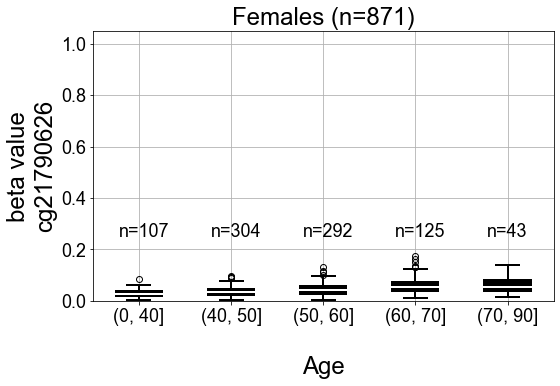

In [31]:
femaleAgePlot = peripheralBloodAgePlot(females, 'Females')
# femaleAgePlot.show()

femaleAgePlot.savefig('Figure3_females.png',
            bbox_inches='tight', pad_inches=0.2, dpi=600)

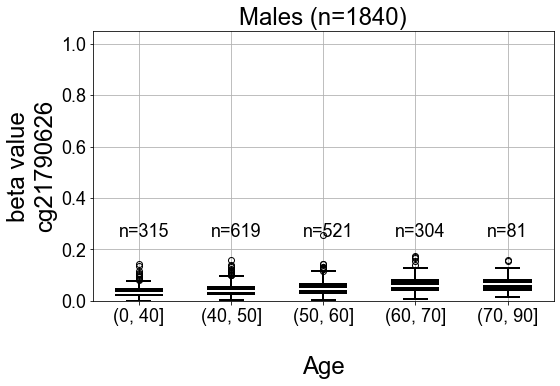

In [32]:
maleAgePlot = peripheralBloodAgePlot(males, 'Males')
# maleAgePlot.show()

maleAgePlot.savefig('Figure3_males.png',
            bbox_inches='tight', pad_inches=0.2, dpi=600)

# Figure 4 - Noncancer diseases

## Path to Beta Values

In [33]:
noncancerBetasPath = 'methylationArrayData/nonCancerDiseases/noncancer_disease_samples_beta_values.csv'

In [34]:
# study_order = ['GSE32148', 'GSE85566', 'PMID24603685',
#                'GSE87621', 'GSE49542', 'GSE50874']

study_order = ['GSE42921', 'GSE81211', 'GSE85566', 'PMID24603685',
               'GSE87621', 'GSE49542', 'GSE50874']

## Processing

In [35]:
noncancerBetas = pd.read_csv(noncancerBetasPath)
noncancerBetas

,sample,Characteristic,cg21790626,study,tissue,notes
0,GSM796660,Crohn's disease,0.033700,GSE32148,peripheral blood,NaN
1,GSM796663,Crohn's disease,0.021980,GSE32148,peripheral blood,NaN
2,GSM796664,Crohn's disease,0.051620,GSE32148,peripheral blood,NaN
3,GSM796680,Crohn's disease,0.025960,GSE32148,peripheral blood,NaN
4,GSM796681,Crohn's disease,0.016670,GSE32148,peripheral blood,NaN
...,...,...,...,...,...,...
393,GSM2144718,Ulcerative colitis,0.339392,GSE81211,colon biopsies,NaN
394,GSM2144719,Ulcerative colitis,0.451558,GSE81211,colon biopsies,NaN
395,GSM2144720,Ulcerative colitis,0.266652,GSE81211,colon biopsies,NaN
396,GSM2144721,Ulcerative colitis,0.318420,GSE81211,colon biopsies,NaN


In [36]:
vals = []
positions = []
colors = []
labels = []

#--------------------------------
# blood_controls = noncancerBetas[(noncancerBetas['study'] == 'GSE32148') & (
#     noncancerBetas['Characteristic'] == 'Controls')]['cg21790626'].values.tolist()
# vals.append(blood_controls)
# positions.append(1)
# colors.append('blue')
# labels.append('Controls')

# blood_crohns = noncancerBetas[(noncancerBetas['study'] == 'GSE32148') & (
#     noncancerBetas['Characteristic'] == "Crohn's disease")]['cg21790626'].values.tolist()
# vals.append(blood_crohns)
# positions.append(2)
# colors.append('red')
# labels.append("Crohn's disease")

# blood_colitis = noncancerBetas[(noncancerBetas['study'] == 'GSE32148') & (
#     noncancerBetas['Characteristic'] == "Ulcerative colitis")]['cg21790626'].values.tolist()
# vals.append(blood_colitis)
# positions.append(3)
# colors.append('red')
# labels.append("Ulcerative colitis")

#--------------------------------
mucosa_controls = noncancerBetas[(noncancerBetas['study'] == 'GSE42921') & (
    noncancerBetas['Characteristic'] == 'normal')]['cg21790626'].values.tolist()
vals.append(mucosa_controls)
positions.append(1)
colors.append('blue')
labels.append('Normal mucosa')

mucosa_crohns = noncancerBetas[(noncancerBetas['study'] == 'GSE42921') & (
    noncancerBetas['Characteristic'] == "Crohn's disease")]['cg21790626'].values.tolist()
vals.append(mucosa_crohns)
positions.append(2)
colors.append('red')
labels.append("Crohn's disease")

mucosa_colitis = noncancerBetas[(noncancerBetas['study'] == 'GSE42921') & (
    noncancerBetas['Characteristic'] == "Ulcerative colitis")]['cg21790626'].values.tolist()
vals.append(mucosa_colitis)
positions.append(3)
colors.append('red')
labels.append("Ulcerative colitis")

#--------------------------------
colon_controls = noncancerBetas[(noncancerBetas['study'] == 'GSE81211') & (
    noncancerBetas['Characteristic'] == 'Normal')]['cg21790626'].values.tolist()
vals.append(colon_controls)
positions.append(4.5)
colors.append('blue')
labels.append('Normal colon')

colon_colitis = noncancerBetas[(noncancerBetas['study'] == 'GSE81211') & (
    noncancerBetas['Characteristic'] == "Ulcerative colitis")]['cg21790626'].values.tolist()
vals.append(colon_colitis)
positions.append(5.5)
colors.append('red')
labels.append("Ulcerative colitis")


#--------------------------------
asthma_control = noncancerBetas[(noncancerBetas['study'] == 'GSE85566') & (
    noncancerBetas['Characteristic'] == "Controls")]['cg21790626'].values.tolist()
vals.append(asthma_control)
positions.append(7)
colors.append('blue')
labels.append("Controls")

asthma = noncancerBetas[(noncancerBetas['study'] == 'GSE85566') & (
    noncancerBetas['Characteristic'] == "Asthma")]['cg21790626'].values.tolist()
vals.append(asthma)
positions.append(8)
colors.append('red')
labels.append("Asthma")

#--------------------------------
t2d_control = noncancerBetas[(noncancerBetas['study'] == 'PMID24603685') & (
    noncancerBetas['Characteristic'] == "Controls")]['cg21790626'].values.tolist()
vals.append(t2d_control)
positions.append(9.5)
colors.append('blue')
labels.append("Controls")

t2d = noncancerBetas[(noncancerBetas['study'] == 'PMID24603685') & (
    noncancerBetas['Characteristic'] == "Type 2 Diabetes")]['cg21790626'].values.tolist()
vals.append(t2d)
positions.append(10.5)
colors.append('red')
labels.append("Type 2 Diabetes")

#--------------------------------
endometrial_control = noncancerBetas[(noncancerBetas['study'] == 'GSE87621') & (
    noncancerBetas['Characteristic'] == "Controls")]['cg21790626'].values.tolist()
vals.append(endometrial_control)
positions.append(12)
colors.append('blue')
labels.append("Controls")

endometriosis = noncancerBetas[(noncancerBetas['study'] == 'GSE87621') & (
    noncancerBetas['Characteristic'] == "Endometriosis")]['cg21790626'].values.tolist()
vals.append(endometriosis)
positions.append(13)
colors.append('red')
labels.append("Endometriosis")

#--------------------------------
nafld_mild = noncancerBetas[(noncancerBetas['study'] == 'GSE49542') & (
    noncancerBetas['Characteristic'] == "NAFLD, Mild")]['cg21790626'].values.tolist()
vals.append(nafld_mild)
positions.append(14.5)
colors.append('red')
labels.append("NAFLD, Mild")

nafld_adv = noncancerBetas[(noncancerBetas['study'] == 'GSE49542') & (
    noncancerBetas['Characteristic'] == "NAFLD, Adv.")]['cg21790626'].values.tolist()
vals.append(nafld_adv)
positions.append(15.5)
colors.append('red')
labels.append("NAFLD, Adv.")

#--------------------------------
kidney = noncancerBetas[(noncancerBetas['study'] == 'GSE50874') & (
    noncancerBetas['Characteristic'] == "Kidney Fibrosis")]['cg21790626'].values.tolist()
vals.append(kidney)
positions.append(17)
colors.append('red')
labels.append("Kidney Fibrosis")

## Plotting

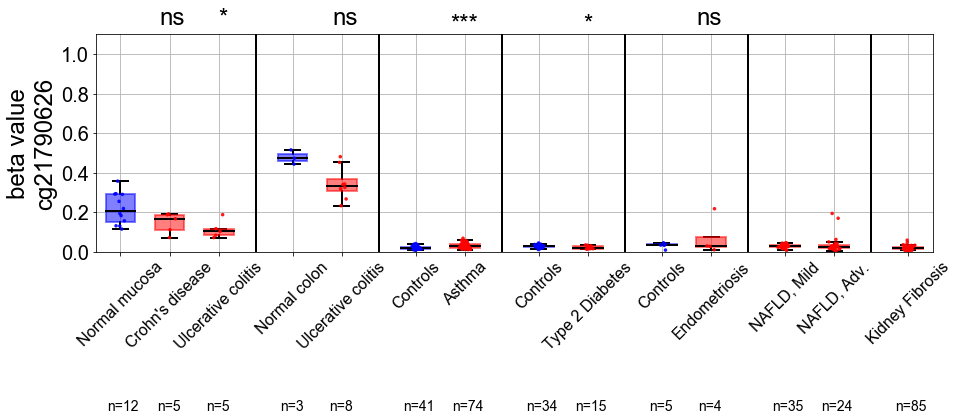

In [37]:
fig, ax = plt.subplots(figsize=(15, 4))

ylimit = 1.10
maxVal = 1.05
ax.set_ylim([0, ylimit])

bp = ax.boxplot(vals, positions=positions,
                widths=0.6, patch_artist=True)

for flier in bp['fliers']:
    flier.set(marker='', color='black')
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=2)
for cap in bp['caps']:
    cap.set(color='black', linewidth=2)
for median in bp['medians']:
    median.set(color='black', linewidth=2)
    
for idx in np.arange(len(vals)):
    
    c = colors[idx]
    
    bp['boxes'][idx].set(color=c, facecolor=lighten_color(
        c), linewidth=2, alpha=0.5)
    scatter = ax.scatter(x=np.random.normal(positions[idx], 0.05, size=len(
        vals[idx])), y=vals[idx], c=[c], marker='.', edgecolors='', s=50, alpha=0.9, zorder=10)
    
    ax.text(x=positions[idx]-0.26, y=-0.8,
            s='n={}'.format(len(vals[idx])), fontsize=14)

ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=16, rotation=45)

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([str(round(i, 1))
                    for i in np.arange(0, 1.1, 0.2)], fontsize=20)
ax.set_ylabel('beta value\ncg21790626', fontsize=24)

ax.axvline(x=3.75, ymin=0, ymax=1.1, color='k', linewidth=2)
ax.axvline(x=6.25, ymin=0, ymax=1.1, color='k', linewidth=2)
ax.axvline(x=8.75, ymin=0, ymax=1.1, color='k', linewidth=2)
ax.axvline(x=11.25, ymin=0, ymax=1.1, color='k', linewidth=2)
ax.axvline(x=13.75, ymin=0, ymax=1.1, color='k', linewidth=2)
ax.axvline(x=16.25, ymin=0, ymax=1.1, color='k', linewidth=2)

# mpl.rcParams['axes.linewidth'] = 2 #set the value globally

#--------------------------------
pval = ranksum(mucosa_controls, mucosa_crohns)
if 0.01 <= pval < 0.05:
    ax.text(x=1, y=1.15, s='*', fontsize=24)
if 0.001 <= pval < 0.01:
    ax.text(x=1, y=1.15, s='**', fontsize=24)
if pval < 0.001:
    ax.text(x=1, y=1.15, s='***', fontsize=24)
if pval >= 0.05:
    ax.text(x=1.8, y=1.15, s='ns', fontsize=24)
    
pval = ranksum(mucosa_controls, mucosa_colitis)
if 0.01 <= pval < 0.05:
    ax.text(x=3, y=1.15, s='*', fontsize=24)
if 0.001 <= pval < 0.01:
    ax.text(x=3, y=1.15, s='**', fontsize=24)
if pval < 0.001:
    ax.text(x=3, y=1.15, s='***', fontsize=24)
if pval >= 0.05:
    ax.text(x=2.8, y=1.15, s='ns', fontsize=24)
    
#--------------------------------
pval = ranksum(colon_controls, colon_colitis)
if 0.01 <= pval < 0.05:
    ax.text(x=5.5, y=1.12, s='*', fontsize=24)
if 0.001 <= pval < 0.01:
    ax.text(x=5.5, y=1.12, s='**', fontsize=24)
if pval < 0.001:
    ax.text(x=5.3, y=1.12, s='***', fontsize=24)
if pval >= 0.05:
    ax.text(x=5.3, y=1.15, s='ns', fontsize=24)
    
#--------------------------------
pval = ranksum(asthma_control, asthma)
if 0.01 <= pval < 0.05:
    ax.text(x=7.95, y=1.12, s='*', fontsize=24)
if 0.001 <= pval < 0.01:
    ax.text(x=7.95, y=1.12, s='**', fontsize=24)
if pval < 0.001:
    ax.text(x=7.7, y=1.12, s='***', fontsize=24)
if pval >= 0.05:
    ax.text(x=8.2, y=1.15, s='ns', fontsize=24)
    
#--------------------------------
pval = ranksum(t2d_control, t2d)
if 0.01 <= pval < 0.05:
    ax.text(x=10.4, y=1.12, s='*', fontsize=24)
if 0.001 <= pval < 0.01:
    ax.text(x=10.5, y=1.12, s='**', fontsize=24)
if pval < 0.001:
    ax.text(x=10.5, y=1.12, s='***', fontsize=24)
if pval >= 0.05:
    ax.text(x=10.3, y=1.15, s='ns', fontsize=24)

#--------------------------------
pval = ranksum(endometrial_control, endometriosis)
if 0.01 <= pval < 0.05:
    ax.text(x=12.5, y=1.12, s='*', fontsize=24)
if 0.001 <= pval < 0.01:
    ax.text(x=12.5, y=1.12, s='**', fontsize=24)
if pval < 0.001:
    ax.text(x=12.5, y=1.12, s='***', fontsize=24)
if pval >= 0.05:
    ax.text(x=12.7, y=1.15, s='ns', fontsize=24)



# plt.title('Noncancer conditions', fontsize=16, y=1.05)
plt.grid()

# plt.show()

fig.savefig('Figure4_v2.png',
            bbox_inches='tight', pad_inches=0.5, dpi=600)

In [38]:
noncancerBetas[ (noncancerBetas['study'] != 'GSE32148') & (noncancerBetas['cg21790626'] > 0.2) ]

,sample,Characteristic,cg21790626,study,tissue,notes
247,GSM2335642,Endometriosis,0.217180,GSE87621,endometrial primary cells,NaN
366,GSM1053382,normal,0.291340,GSE42921,colon mucosa samples,NaN
367,GSM1053383,normal,0.218250,GSE42921,colon mucosa samples,NaN
368,GSM1053384,normal,0.293460,GSE42921,colon mucosa samples,NaN
369,GSM1053385,normal,0.289720,GSE42921,colon mucosa samples,NaN
370,GSM1053386,normal,0.254440,GSE42921,colon mucosa samples,NaN
376,GSM1053392,normal,0.356810,GSE42921,colon mucosa samples,NaN
387,GSM2144712,Normal,0.472643,GSE81211,colon biopsies,NaN
388,GSM2144713,Normal,0.442712,GSE81211,colon biopsies,NaN
389,GSM2144714,Normal,0.514901,GSE81211,colon biopsies,NaN


In [39]:
noncancerBetas[ (noncancerBetas['study'] != 'GSE32148') & (noncancerBetas['cg21790626'] > 0.2) ].shape

(18, 6)

# Figure 5 - Methylated ZNF154 copies per mL classification

## Paths to data

In [40]:
ovarianCountsMD0raw = pd.read_csv(
    "plasma/ovarianNormalizedMethylatedZNFCounts.csv")
ovarianReadCountsMD0 = ovarianCountsMD0raw['cases'].dropna().values.tolist()
controlsReadCountsMD0 = ovarianCountsMD0raw['controls'].dropna().values.tolist()

pancreasLateCountsMD0raw = pd.read_csv(
    "plasma/pancreasLateNormalizedMethylatedZNFCounts.csv")
pancreasLateReadCountsMD0 = pancreasLateCountsMD0raw['cases'].dropna().values.tolist()

pancreasEarlyCountsMD0raw = pd.read_csv(
    "plasma/pancreasEarlyNormalizedMethylatedZNFCounts.csv")
pancreasEarlyReadCountsMD0 = pancreasEarlyCountsMD0raw['cases'].dropna().values.tolist()

liverCountsMD0raw = pd.read_csv(
    "plasma/liverNormalizedMethylatedZNFCounts.csv")
liverReadCountsMD0 = liverCountsMD0raw['cases'].dropna().values.tolist()

colonCountsMD0raw = pd.read_csv(
    "plasma/colonNormalizedMethylatedZNFCounts.csv")
colonReadCountsMD0 = colonCountsMD0raw['cases'].dropna().values.tolist()

## Plotting - Figure 5A

Stats:
Control median = 11.380097927191464
Pancreas Late median = 19.471677563889912
Pancreas Early median = 18.610671265124253
Ovarian median = 27.30264166496678
 
 
Rank sum p-values:
Control vs Pancreas Late rank sum = 0.00028711571884950185
Control vs Pancreas Early rank sum = 0.002695978247598541
Control vs Ovarian rank sum = 1.456636317002911e-05
 


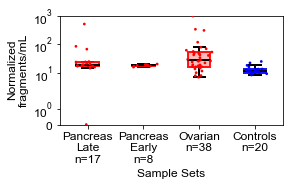

In [41]:
boxes = [pancreasLateReadCountsMD0, pancreasEarlyReadCountsMD0, ovarianReadCountsMD0, controlsReadCountsMD0]
positions = [1, 2, 3, 4]
colors = ['red', 'red', 'red', 'blue']
xlabels = ['Pancreas\nLate\nn={}'.format(len(pancreasLateReadCountsMD0)),
           'Pancreas\nEarly\nn={}'.format(len(pancreasEarlyReadCountsMD0)),
           'Ovarian\nn={}'.format(len(ovarianReadCountsMD0)),
           'Controls\nn={}'.format(len(controlsReadCountsMD0))]

fig, ax = plt.subplots(figsize=(4, 2))
bp = ax.boxplot(boxes, positions=positions, widths=0.4, patch_artist=True)

for flier in bp['fliers']:
    flier.set(marker='', color='black')
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=2)
for cap in bp['caps']:
    cap.set(color='black', linewidth=2)
for median in bp['medians']:
    median.set(color='black', linewidth=2)

for i in np.arange(len(boxes)):
    bp['boxes'][i].set(color=colors[i], linewidth=2, alpha=0.9)
    bp['boxes'][i].set(facecolor=lighten_color(colors[i]))
    scatter = ax.scatter(x=np.random.normal(positions[i], 0.1, size=len(boxes[i])),
                         y=boxes[i], c=colors[i], marker='.', edgecolors='', s=30, zorder=10)

ax.set_ylim([0, 1000])
plt.yscale('symlog')

ax.set_xticklabels(xlabels, fontsize=12)
ax.set_xlabel('Sample Sets', fontsize=12)
ax.set_ylabel('Normalized\nfragments/mL', fontsize=12)
plt.yticks(fontsize=12)


# plt.show()

print('Stats:')
print("Control median = {}".format(np.median(controlsReadCountsMD0)))
print("Pancreas Late median = {}".format(np.median(pancreasLateReadCountsMD0)))
print("Pancreas Early median = {}".format(np.median(pancreasEarlyReadCountsMD0)))
print("Ovarian median = {}".format(np.median(ovarianReadCountsMD0)))
print(' ')
# print("Colon median = {}".format(np.median(colonReadCountsMD0)))
# print("Liver median = {}".format(np.median(liverReadCountsMD0)))

print(' ')

print('Rank sum p-values:')
print("Control vs Pancreas Late rank sum = {}".format(ranksum(controlsReadCountsMD0, pancreasLateReadCountsMD0)))
print("Control vs Pancreas Early rank sum = {}".format(ranksum(controlsReadCountsMD0, pancreasEarlyReadCountsMD0)))
print("Control vs Ovarian rank sum = {}".format(ranksum(controlsReadCountsMD0, ovarianReadCountsMD0)))
print(' ')
# print("Control vs Colon rank sum = {}".format(ranksum(controlsReadCountsMD0, colonReadCountsMD0)))
# print("Control vs Liver rank sum = {}".format(ranksum(controlsReadCountsMD0, liverReadCountsMD0)))

plt.savefig('Figure5A.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

## Plotting - Figure 5B

AUC = 0.85
optimal cutoff = 14.686363640043234
sensitivity = 0.9411764705882353
specificity = 0.8


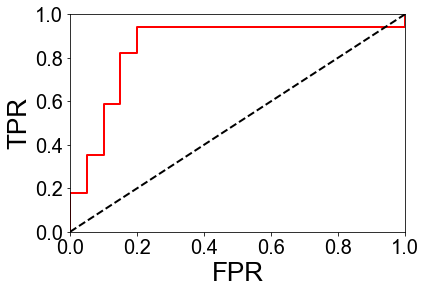

In [42]:
latePancAndControls = pd.DataFrame( [pancreasLateReadCountsMD0, controlsReadCountsMD0]).T
latePancreasROC = rocplot(latePancAndControls)

# latePancreasROC.plot().show()

print('AUC = {}'.format(latePancreasROC.AUC))
print('optimal cutoff = {}'.format(latePancreasROC.optimal_threshold))
print('sensitivity = {}'.format(latePancreasROC.sensitivity))
print('specificity = {}'.format(latePancreasROC.specificity))

latePancreasROC.plot().savefig(
    'Figure5B_latePanc.ROC.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

AUC = 0.86875
optimal cutoff = 15.957980976458964
sensitivity = 1.0
specificity = 0.8


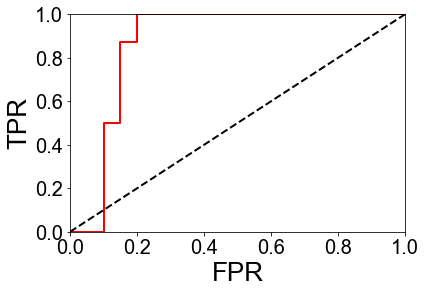

In [43]:
earlyPancAndControls = pd.DataFrame( [pancreasEarlyReadCountsMD0, controlsReadCountsMD0]).T
earlyPancreasROC = rocplot(earlyPancAndControls)

# earlyPancreasROC.plot().show()

print('AUC = {}'.format(earlyPancreasROC.AUC))
print('optimal cutoff = {}'.format(earlyPancreasROC.optimal_threshold))
print('sensitivity = {}'.format(earlyPancreasROC.sensitivity))
print('specificity = {}'.format(earlyPancreasROC.specificity))

earlyPancreasROC.plot().savefig(
    'Figure5B_earlyPanc.ROC.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

AUC = 0.8486842105263158
optimal cutoff = 13.812514647073064
sensitivity = 0.868421052631579
specificity = 0.8


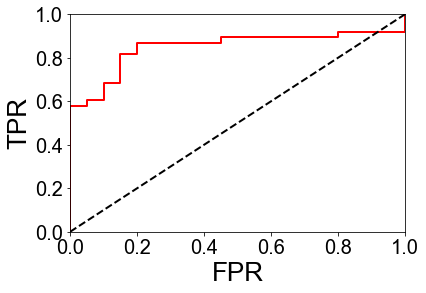

In [44]:
ovarianAndControls = pd.DataFrame( [ovarianReadCountsMD0, controlsReadCountsMD0]).T
ovarianROC = rocplot(ovarianAndControls)

# ovarianROC.plot().show()

print('AUC = {}'.format(ovarianROC.AUC))
print('optimal cutoff = {}'.format(ovarianROC.optimal_threshold))
print('sensitivity = {}'.format(ovarianROC.sensitivity))
print('specificity = {}'.format(ovarianROC.specificity))

ovarianROC.plot().savefig(
    'Figure5B_ovarian.ROC.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

# Figure 6 - KRAS MtAF

## Load Data

In [45]:
krasMtAFPath = 'plasma/KRASddPCRcounts.csv'
kras_copies = pd.read_csv(krasMtAFPath)

In [46]:
plasmaSamplesTablePath = 'plasma/TableS2_plasmaSamples.csv'
samples = pd.read_csv(plasmaSamplesTablePath)

In [47]:
# pancreas and control samples
late_stage = ['112303', '111515', '100815', '101181', '106979', '107754', '111389', '104921',
              '108126', '106239', '106615', '112255', '113396', '127267', '131056', '141239', '113852']
early_stage = ['133019', '133069', '112944',
               '122947', '106646', '107187', '104422', '107695']
controls = ['104876', '102109', '101825', '103566', '101747', '103116', '102172', '101937', '101799',
            '102059', '101786', '102029', '109195', '109608', '106846', '108028', '104617', '103110', '109162', '100545']

## Process Data

In [48]:
kras_copies_combined = kras_copies.groupby(['Sample']).sum()
kras_copies_combined['samples'] = kras_copies_combined.index.values

kras_copies_combined['total_copies'] = kras_copies_combined['MUT copies'] + \
    kras_copies_combined['WT copies']
kras_copies_combined['MAF'] = kras_copies_combined['MUT copies'] / \
    kras_copies_combined['total_copies']

sample_plasma = samples[['samples', 'mLs_plasma', 'type', 'stage']]

kras_copies_combined_with_plasma = pd.merge(
    kras_copies_combined, sample_plasma, on='samples')

kras_copies_combined_with_plasma['fraction'] = 0.8

kras_copies_combined_with_plasma['adj_MAF'] = kras_copies_combined_with_plasma['MAF'] / (
    kras_copies_combined_with_plasma['mLs_plasma'] * kras_copies_combined_with_plasma['fraction'])

# kras_copies_combined_with_plasma.to_csv('KRAS_MtAF_Table_S3.csv')

kras_copies_combined_with_plasma

,MUT copies,WT copies,samples,total_copies,MAF,mLs_plasma,type,stage,fraction,adj_MAF
0,1.8,5440,100545,5441.8,0.000331,3.25,control,NaN,0.8,0.000127
1,7.6,1962,100815,1969.6,0.003859,1.85,pancreas,4A,0.8,0.002607
2,0.0,6480,101181,6480.0,0.000000,1.50,pancreas,4A,0.8,0.000000
3,0.0,902,101747,902.0,0.000000,3.00,control,NaN,0.8,0.000000
4,0.0,1746,101786,1746.0,0.000000,3.00,control,NaN,0.8,0.000000
5,0.0,2480,101799,2480.0,0.000000,3.00,control,NaN,0.8,0.000000
6,0.0,1626,101825,1626.0,0.000000,3.25,control,NaN,0.8,0.000000
7,0.0,648,101937,648.0,0.000000,3.25,control,NaN,0.8,0.000000
8,1.8,4680,102029,4681.8,0.000384,3.25,control,NaN,0.8,0.000148
9,0.0,2224,102059,2224.0,0.000000,3.20,control,NaN,0.8,0.000000


In [49]:
# KRAS MtAF data
late = kras_copies_combined_with_plasma[kras_copies_combined_with_plasma['samples'].isin(
    late_stage)][['samples', 'adj_MAF']]
early = kras_copies_combined_with_plasma[kras_copies_combined_with_plasma['samples'].isin(
    early_stage)][['samples', 'adj_MAF']]
control = kras_copies_combined_with_plasma[kras_copies_combined_with_plasma['samples'].isin(
    controls)][['samples', 'adj_MAF']]

In [50]:
late_table = pd.DataFrame(
    [late['adj_MAF'].values.tolist(), control['adj_MAF'].values.tolist()]).T
early_table = pd.DataFrame(
    [early['adj_MAF'].values.tolist(), control['adj_MAF'].values.tolist()]).T

all_table = pd.DataFrame(
    [early['adj_MAF'].values.tolist() + late['adj_MAF'].values.tolist(), control['adj_MAF'].values.tolist()]).T

In [51]:
earlyMAF = early_table.loc[:,0].dropna().values.tolist()
lateMAF = late_table.loc[:,0].dropna().values.tolist()
controlMAF = late_table.loc[:,1].dropna().values.tolist()

## Plotting - Figure 6A

statistics:
Control median = 0.0
Pancreas Late median = 0.0007066538526768047
Pancreas Early median = 0.0
 
rank sum p-values:
Control vs Pancreas Late rank sum = 0.0243105105152741
Control vs Pancreas Early rank sum = 0.9716422524519456


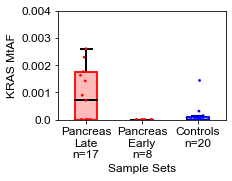

In [52]:
boxes = [lateMAF, earlyMAF, controlMAF]
positions = [1, 2, 3]
colors = ['red', 'red', 'blue']
xlabels = ['Pancreas\nLate\nn=17', 'Pancreas\nEarly\nn=8', 'Controls\nn=20']

fig, ax = plt.subplots(figsize=(3, 2))
bp = ax.boxplot(boxes, positions=positions, widths=0.4, patch_artist=True)

for flier in bp['fliers']:
    flier.set(marker='', color='black')
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=2)
for cap in bp['caps']:
    cap.set(color='black', linewidth=2)
for median in bp['medians']:
    median.set(color='black', linewidth=2)

for i in np.arange(len(boxes)):
    bp['boxes'][i].set(color=colors[i], linewidth=2, alpha=0.9)
    bp['boxes'][i].set(facecolor=lighten_color(colors[i]))
    scatter = ax.scatter(x=np.random.normal(positions[i], 0.1, size=len(boxes[i])),
                         y=boxes[i], c=colors[i], marker='.', edgecolors='', s=30, zorder=10)

ax.set_ylim([0, 0.004])

ax.set_xticklabels(xlabels, fontsize=12)
ax.set_xlabel('Sample Sets', fontsize=12)
ax.set_ylabel('KRAS MtAF', fontsize=12)

ax.set_yticks([0.0, 0.001, 0.002, 0.003, 0.004])
ax.set_yticklabels([0.0, 0.001, 0.002, 0.003, 0.004], fontsize=12)


# plt.show()

print('statistics:')
print("Control median = {}".format(np.median(controlMAF)))
print("Pancreas Late median = {}".format(np.median(lateMAF)))
print("Pancreas Early median = {}".format(np.median(earlyMAF)))
print(' ')
print('rank sum p-values:')
s1, p1 = stats.mannwhitneyu(controlMAF, lateMAF, alternative='less')
print("Control vs Pancreas Late rank sum = {}".format(p1))
s2, p2 = stats.mannwhitneyu(controlMAF, earlyMAF, alternative='less')
print("Control vs Pancreas Early rank sum = {}".format(p2))

plt.savefig('MtAF-Figure6A.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

## Plotting - Figure 6B

AUC = 0.6735294117647059
optimal cutoff = 0.0007066538526768047
sensitivity = 0.5294117647058824
specificity = 0.95


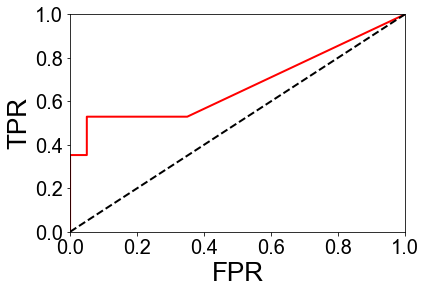

In [53]:
latePancAndControlsMtAF = pd.DataFrame( [lateMAF, controlMAF]).T
latePancreasROCMtAF = rocplot(latePancAndControlsMtAF)

# latePancreasROCMtAF.plot().show()

print('AUC = {}'.format(latePancreasROCMtAF.AUC))
print('optimal cutoff = {}'.format(latePancreasROCMtAF.optimal_threshold))
print('sensitivity = {}'.format(latePancreasROCMtAF.sensitivity))
print('specificity = {}'.format(latePancreasROCMtAF.specificity))

latePancreasROCMtAF.plot().savefig(
    'Figure6B_latePancMtAF.ROC.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

# Supplemental Figure S2 - Age Distributions

## Load Data

In [54]:
plasmaSamplesTablePath = 'plasma/TableS2_plasmaSamples.csv'
samples = pd.read_csv(plasmaSamplesTablePath)

In [55]:
agesControl = samples[samples['type'] == 'control']['age'].values.tolist()
agesOv = samples[samples['type'] == 'ovarian']['age'].values.tolist()
agesLiver = samples[samples['type'] == 'liver']['age'].values.tolist()
agesPancreas = samples[samples['type'] == 'pancreas']['age'].values.tolist()
agesColon = samples[samples['type'] == 'colon']['age'].values.tolist()

## Plotting

Control median age = 71.5
Ovarian median age = 59.0
Pancreas median age = 60.0
Liver median age = 61.5
Colon median age = 64.0
Control vs Ovarian rank sum = 0.0009795108625726403
Control vs Pancreas rank sum = 0.0018215713053827594
Control vs Liver rank sum = 0.20121963204655913
Control vs Colon rank sum = 0.3941828248630501


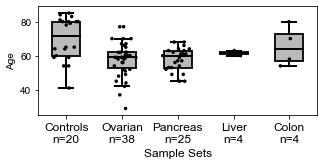

In [56]:
boxes = [agesControl, agesOv, agesPancreas, agesLiver, agesColon]
positions = [1, 2, 3, 4, 5]
xlabels = ['Controls\nn=20', 'Ovarian\nn=38', 'Pancreas\nn=25', 'Liver\nn=4', 'Colon\nn=4']

fig, ax = plt.subplots(figsize=(5, 2))
bp = ax.boxplot(boxes, positions=positions, widths=0.5, patch_artist=True)

for flier in bp['fliers']:
    flier.set(marker='', color='black')
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=2)
for cap in bp['caps']:
    cap.set(color='black', linewidth=2)
for median in bp['medians']:
    median.set(color='black', linewidth=2)

for i in np.arange(len(boxes)):
    bp['boxes'][i].set(color="black", linewidth=2, alpha=0.9)
    bp['boxes'][i].set(facecolor=lighten_color("black"))
    scatter = ax.scatter(x=np.random.normal(positions[i], 0.1, size=len(boxes[i])),
                         y=boxes[i], c="black", marker='.', edgecolors='', s=50, zorder=10)

#         ax.set_xlim([0, max(self.positions)+1])
#         ax.set_ylim([0, self.maxVal * 1.1])
#         ax.set_ylabel(self.ytitle, fontsize=18)
#         plt.yticks(np.linspace(0, self.maxVal*1.05, 5), ['0.0']+['%.1e' % i for i in np.linspace(0, self.maxVal*1.05, 5)[1:]],
#                    fontsize=12)
#         plt.yscale('symlog')
#         ax.set_xlabel(self.xtitle, fontsize=24)
#         ax.set_xticklabels(self.labels, fontsize=12, rotation=45)
#         plt.title(self.title, fontsize=18)

ax.set_xticklabels(xlabels, fontsize=12)
ax.set_xlabel('Sample Sets', fontsize=12)
ax.set_ylabel('Age')


# plt.show()

print("Control median age = {}".format(np.median(agesControl)))
print("Ovarian median age = {}".format(np.median(agesOv)))
print("Pancreas median age = {}".format(np.median(agesPancreas)))
print("Liver median age = {}".format(np.median(agesLiver)))
print("Colon median age = {}".format(np.median(agesColon)))

print("Control vs Ovarian rank sum = {}".format(ranksum(agesControl, agesOv)))
print("Control vs Pancreas rank sum = {}".format(ranksum(agesControl, agesPancreas)))
print("Control vs Liver rank sum = {}".format(ranksum(agesControl, agesLiver)))
print("Control vs Colon rank sum = {}".format(ranksum(agesControl, agesColon)))

plt.savefig('FigS2_SampleCohortsAges.png', bbox_inches='tight', pad_inches=0.5, dpi=600)

# Supplemental Figure S3 - Colon and Liver methylated ZNF154 classification

## Load Data

In [57]:
liverCountsMD0raw = pd.read_csv(
    "plasma/liverNormalizedMethylatedZNFCounts.csv")
liverReadCountsMD0 = liverCountsMD0raw['cases'].dropna().values.tolist()

colonCountsMD0raw = pd.read_csv(
    "plasma/colonNormalizedMethylatedZNFCounts.csv")
colonReadCountsMD0 = colonCountsMD0raw['cases'].dropna().values.tolist()

## Plotting

Stats:
 
Colon median = 64.48980581387261
Liver median = 14.560182484253637
 
Rank sum p-values:
 
Control vs Colon rank sum = 0.12133525035848211
Control vs Liver rank sum = 0.8768849114533788


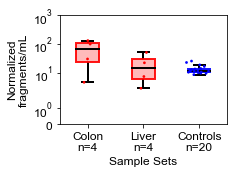

In [58]:
boxes = [colonReadCountsMD0, liverReadCountsMD0, controlsReadCountsMD0]
positions = [1, 2, 3]
colors = ['red', 'red', 'blue']
xlabels = ['Colon\nn={}'.format(len(colonReadCountsMD0)),
           'Liver\nn={}'.format(len(liverReadCountsMD0)),
           'Controls\nn={}'.format(len(controlsReadCountsMD0))]

fig, ax = plt.subplots(figsize=(3, 2))
bp = ax.boxplot(boxes, positions=positions, widths=0.4, patch_artist=True)

for flier in bp['fliers']:
    flier.set(marker='', color='black')
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=2)
for cap in bp['caps']:
    cap.set(color='black', linewidth=2)
for median in bp['medians']:
    median.set(color='black', linewidth=2)

for i in np.arange(len(boxes)):
    bp['boxes'][i].set(color=colors[i], linewidth=2, alpha=0.9)
    bp['boxes'][i].set(facecolor=lighten_color(colors[i]))
    scatter = ax.scatter(x=np.random.normal(positions[i], 0.1, size=len(boxes[i])),
                         y=boxes[i], c=colors[i], marker='.', edgecolors='', s=30, zorder=10)

ax.set_ylim([0, 1000])
plt.yscale('symlog')

ax.set_xticklabels(xlabels, fontsize=12)
ax.set_xlabel('Sample Sets', fontsize=12)
ax.set_ylabel('Normalized\nfragments/mL', fontsize=12)
plt.yticks(fontsize=12)


# plt.show()

print('Stats:')
# print("Control median = {}".format(np.median(controlsReadCountsMD0)))
# print("Pancreas Late median = {}".format(np.median(pancreasLateReadCountsMD0)))
# print("Pancreas Early median = {}".format(np.median(pancreasEarlyReadCountsMD0)))
# print("Ovarian median = {}".format(np.median(ovarianReadCountsMD0)))
print(' ')
print("Colon median = {}".format(np.median(colonReadCountsMD0)))
print("Liver median = {}".format(np.median(liverReadCountsMD0)))

print(' ')

print('Rank sum p-values:')
# print("Control vs Pancreas Late rank sum = {}".format(ranksum(controlsReadCountsMD0, pancreasLateReadCountsMD0)))
# print("Control vs Pancreas Early rank sum = {}".format(ranksum(controlsReadCountsMD0, pancreasEarlyReadCountsMD0)))
# print("Control vs Ovarian rank sum = {}".format(ranksum(controlsReadCountsMD0, ovarianReadCountsMD0)))
print(' ')
print("Control vs Colon rank sum = {}".format(ranksum(controlsReadCountsMD0, colonReadCountsMD0)))
print("Control vs Liver rank sum = {}".format(ranksum(controlsReadCountsMD0, liverReadCountsMD0)))

plt.savefig('SuppFigS3_Colon_Liver.png', bbox_inches='tight', pad_inches=0.5, dpi=600)